In [203]:
import pandas as pd
import numpy as np
import scipy.stats
import random


# geo
from pygeotile.tile import Tile
from geopy.geocoders import Nominatim
import folium

%matplotlib inline

In [89]:
R = 0.02
def metrics(lat_hat, lon_hat, lat_real, lon_real):
    lat = np.power(lat_hat - lat_real, 2)
    lon = np.power(lon_hat - lon_real, 2)
    return np.power(lat + lon, 0.5) < R

def score(predictions_home, predictions_work, real_coords_home, real_coords_work):
    score = 0
    for pred_h, real_h, pred_w, real_w in list(zip(predictions_home, real_coords_home
                                                   , predictions_work, real_coords_work)):
        
        m_h = metrics(pred_h[0], pred_h[1], real_h[0], real_h[1])
        m_w = metrics(pred_w[0], pred_w[1], real_w[0], real_w[1])
        score = score + (m_h + m_w) / 2

                    
    return score / len(predictions_home)

In [90]:
def preprosses(dataframe, df_mcc):
    # объединим координаты банкоматов и прочих транзакций, сформировав единое представление о координатах
    dataframe['tran_lat'] = np.where(dataframe["atm_address_lat"].isnull(),
                                    dataframe["pos_adress_lat"], dataframe["atm_address_lat"])
    dataframe['tran_lon'] = np.where(dataframe["atm_address_lon"].isnull(),
                                    dataframe["pos_adress_lon"], dataframe["atm_address_lon"])
    
    dataframe = pd.merge(dataframe, df_mcc, left_on = 'mcc', right_on='MCC')
    
    # те mcc коды, которые не смержились, можно убрать
    dataframe = dataframe[~dataframe["Description_1_code"].isnull()]
    dataframe["Description_1_code"]  = dataframe["Description_1_code"].replace({41: 19})  
    print (dataframe.customer_id.nunique())
    dataframe.drop(['MCC','pos_adress_lat','pos_adress_lon','atm_address_lat','atm_address_lon'], axis = 1, inplace = True)
    return dataframe

In [91]:
df_train = pd.read_csv('data/train_set.csv', low_memory=False)

In [92]:
df_train.head(4)

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
1,2.775633,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,2017-10-27,59.847,30.177
2,3.708368,NaN,NaN,NaN,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,2017-10-03,59.847,30.177
3,2.787498,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177


In [93]:
df_train.city.value_counts().head(5)

MOSCOW           267527
SANKT-PETERBU    150037
MOSKVA            79696
MOSKVA            75072
ST-PETERSBURG     19544
Name: city, dtype: int64

Видим, что городов очень много. Стоит расмотреть следущие варианты:
    - заменить редкие попадания на 'other', большие города объединить
    - если в тех городах никто не живёт - выкинуть из рассмотрения
    - тайлировать координаты, чтобы избавиться от этой переменной
    - использовать osmapi чтобы получить реальные города

In [94]:
#Похоже, у некоторых людей несколько адресов
adress_home = df_train[['home_add_lat','home_add_lon']].drop_duplicates()
print (adress_home.shape)
# а чуть более не работают
adress_work = df_train[['work_add_lat','work_add_lon']].drop_duplicates()
print (adress_work.shape)

(10147, 2)
(4585, 2)


Получается, что кто-то переезжал, а кто-то безработный, а у кого-то несколько работ

In [95]:
df_train.groupby('customer_id')['city'].apply(set).head()

customer_id
0001f322716470bf9bfc1708f06f00fc    {TSEMDOLINA S., NOVOROSIYSK, NOVOROSSIIYSK, NO...
0007297d86e14bd68bd87b1dbdefe302    {MOSCOW       , Moskva, MOSKOW, MOSKVA       ,...
000b709c6c6fb1e8efcfd95e57c2a9de    {KEMEROVO, NVSIBR, IRKUTSK, DOMODEDOVO, TOMSK ...
0027a7618d97cc9fbda55fac457eaeb7    {LESNOJ GORODO, LESNOY, MOSCOW, YUDINO, VARNA ...
002b9f6e118c54f1292e03d1a04d516e    {MOSCOW       , G MOSKVA, Rhodes       , Moskv...
Name: city, dtype: object

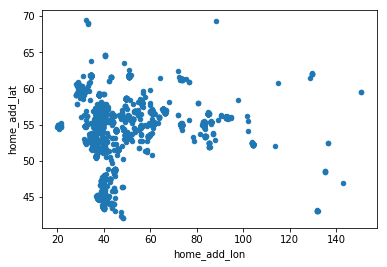

In [96]:
#Что-ж, картинка слабо напоминает хоть что-то, попробуем визуализировать кусками, похоже, что есть ошибки
adress_home_msk = df_train[['home_add_lat','home_add_lon']].drop_duplicates()
adress_home_msk.plot(y = 'home_add_lat', x = 'home_add_lon', kind = 'scatter');

In [97]:
# загрузим упрощённое описание mcc кодов
df_mcc = pd.read_excel('data/mcc.xlsx')
df_mcc = df_mcc[['MCC', 'Description_1_code']]
df_train = preprosses(df_train, df_mcc)

10000


In [104]:
adress_home_msk = adress_home_msk.fillna(0)

In [105]:
adress_home_msk.shape

(10147, 2)

In [ ]:
#  ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
#  |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
#  |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
#  |           'gray', 'black', 'lightgray']

In [224]:
def plot_one_person(person_id, df):
    transactions = df[df.customer_id == person_id]
    home_address = transactions[['home_add_lat','home_add_lon']].drop_duplicates()
    work_address = transactions[['work_add_lat','work_add_lon']].drop_duplicates()

    map_osm = folium.Map(location=[home_address.iloc[0][0],home_address.iloc[0][1]])
    transactions_disct = transactions[['terminal_id','tran_lat','tran_lon', 'Description_1_code']].drop_duplicates()
    transactions_disct.dropna(inplace = True)
    home_address.dropna(inplace = True)
    work_address.dropna(inplace = True)
    
    print (home_address)
    print (work_address)
     
    # рисуем дом
    for idx, homes in home_address.iterrows():
        folium.Marker([homes['home_add_lat'], homes['home_add_lon']],
               popup=person_id,
              icon=folium.Icon(color='blue',icon='home')
              ).add_to(map_osm)
        
        folium.Circle([homes['home_add_lat'], homes['home_add_lon']],
                    radius= abs(int(0.02 * 113.320 * np.cos(homes['home_add_lat']) * 1000)),
                    color='blue',
                    fill_color='#3186cc',
                   ).add_to(map_osm)

    # рисуем работу
    for idx, works in work_address.iterrows():
        folium.Marker([works['work_add_lat'], works['work_add_lon']],
               popup=person_id,
              icon=folium.Icon(color='black',icon='briefcase')
              ).add_to(map_osm)  
        
        folium.Circle([works['work_add_lat'], works['work_add_lon']],
            radius= abs(int(0.02 * 113.320 * np.cos(works['work_add_lat']) * 1000)),
            color='black',
            fill_color='#3186cc',
           ).add_to(map_osm)


    dict_icons = {22: 'credit-card', 10: 'shopping-cart', 19: 'beer'}
    dict_colors = {22: 'green', 10: 'lightblue', 19: 'orange'}
    
    for idx, trans in transactions_disct.iterrows():
        color = dict_colors.get(trans['Description_1_code'], "pink")
        icon = dict_icons.get(trans['Description_1_code'], "info-sign")
        folium.Marker([trans['tran_lat'], trans['tran_lon']],
               popup=trans['terminal_id'],
              icon=folium.Icon(color=color, icon=icon)
              ).add_to(map_osm)
    map_osm.save('tmp/' + person_id + '.html')

In [225]:
# plot_one_person('0dc0137d280a2a82d2dc89282450ff1b', df_train)

In [226]:
customers = df_train['customer_id'].unique()

In [227]:
random.shuffle(customers)

In [228]:
for c in customers[0:10]:
    plot_one_person(c, df_train)

        home_add_lat  home_add_lon
228180        53.841         37.34
        work_add_lat  work_add_lon
228180        54.186        37.547
       home_add_lat  home_add_lon
12967        55.757        37.855
       work_add_lat  work_add_lon
12967        55.791         37.61
        home_add_lat  home_add_lon
217819        55.764        37.586
        work_add_lat  work_add_lon
217819        55.771        37.641
        home_add_lat  home_add_lon
213226         44.68        37.795
Empty DataFrame
Columns: [work_add_lat, work_add_lon]
Index: []
        home_add_lat  home_add_lon
357333         55.83        37.329
        work_add_lat  work_add_lon
357333        55.744        37.436
     home_add_lat  home_add_lon
204        55.724        37.599
     work_add_lat  work_add_lon
204        55.747        37.404
      home_add_lat  home_add_lon
5165        58.601        49.663
      work_add_lat  work_add_lon
5165        58.602        49.678
        home_add_lat  home_add_lon
214769        5

Очень многие банкоматы не имеют координат, это плохо: но попробуем восстановить через имеющийся адрес

In [14]:
df_train.shape

(1224734, 15)

In [131]:
# те mcc коды, которые не смержились, можно убрать
df_train = df_train[~df_train["Description_1_code"].isnull()]

In [139]:
#гипотеза 1: покупает дома в магазинах, на работе ходит в кафе-рестораны

In [141]:
df_train_hup_1 = df_train[df_train['Description_1_code'].isin([10,19])]

In [149]:
# df_train_hup_1.groupby(['customer_id','Description_1_code'])['Description_1_code'].count()

In [213]:
clients_h = df_train[['customer_id','home_add_lat','home_add_lon']].drop_duplicates()
clients_w = df_train[['customer_id','work_add_lat','work_add_lon']].drop_duplicates()

real_h_coords = list(zip(clients_h['home_add_lat'],clients_h['home_add_lon']))
real_w_coords = list(zip(clients_w['work_add_lat'],clients_w['work_add_lon']))

In [214]:
score(real_h_coords, real_w_coords, real_h_coords, real_w_coords)

0.5036277449937119

In [228]:
tmp = df_train.groupby(['customer_id','terminal_id'])['terminal_id'].count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             

In [279]:
terminals = df_train[['terminal_id','tran_lat','tran_lon']].drop_duplicates()
terminals.terminal_id.nunique()
terminals_mcc = df_train[['terminal_id', 'Description_1_code']].drop_duplicates()

In [251]:
# terminals1 = terminals.groupby('terminal_id')[['tran_lat','tran_lon']].apply(np.mean)
# terminals1 = terminals.reset_index()

In [280]:
# terminals1 = terminals1.merge(terminals_mcc, left_on = 'terminal_id', right_on = 'terminal_id')

In [281]:
# df_train.terminal_id.nunique()

In [282]:
# tmp.merge(terminals1, left_on = 'terminal_id', right_on = 'terminal_id')

In [283]:
df_train.transaction_date.min()
df_train.transaction_date.max()

'2017-01-27'

In [285]:
# отобразить клиента и его самые частые транзакции
# один терминал - один mcc - одна координата
# один клиент - одна координата (last transaction)
# сделать сабмит клиент - самая часто встречающаяся координата

In [299]:
terminals_mcc = terminals_mcc.groupby('terminal_id')['terminal_id'].count().reset_index(name='count')

In [302]:
terminals_mcc = terminals_mcc[terminals_mcc['count'] == 1]

In [304]:
df_train = df_train[df_train.terminal_id.isin(terminals_mcc.terminal_id)]

In [309]:
df_train[df_train.terminal_id == '0004b2a8bef47fa9af780c7679aba5d1']

,amount,atm_address,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,terminal_id,transaction_date,work_add_lat,work_add_lon,tran_lat,tran_lon,MCC,Description_1_code
942616,3.290224,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,97b421fd894007e250dab809624c995b,55.659,37.502,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-08-15,NaN,NaN,55.744,37.663,6011,22
942617,4.256019,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,9121bf57cc093107f5d04e349b0a8097,55.824,37.804,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-06-27,55.741,37.664,55.741,37.665,6011,22
942618,4.402484,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,9121bf57cc093107f5d04e349b0a8097,55.824,37.804,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-11-02,55.741,37.664,55.741,37.667,6011,22
942619,3.601407,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,9121bf57cc093107f5d04e349b0a8097,55.824,37.804,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-02-10,55.741,37.664,55.743,37.662,6011,22
942620,4.154766,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,97b421fd894007e250dab809624c995b,55.659,37.502,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-03-24,NaN,NaN,55.742,37.668,6011,22
942621,3.706789,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,9121bf57cc093107f5d04e349b0a8097,55.824,37.804,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-07-03,55.741,37.664,55.737,37.667,6011,22
942622,3.292168,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,9121bf57cc093107f5d04e349b0a8097,55.824,37.804,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-06-29,55.741,37.664,55.744,37.666,6011,22
942623,3.993990,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,97b421fd894007e250dab809624c995b,55.659,37.502,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-08-30,NaN,NaN,55.737,37.663,6011,22
942624,3.306480,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,97b421fd894007e250dab809624c995b,55.659,37.502,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-06-20,NaN,NaN,55.740,37.664,6011,22
942625,3.942296,"Москва, ул. Таганская, д. 17-23",MOSCOW,RUS,643.0,97b421fd894007e250dab809624c995b,55.659,37.502,6011,0004b2a8bef47fa9af780c7679aba5d1,2017-04-10,NaN,NaN,55.741,37.664,6011,22


In [322]:
min_coords_lat = df_train.groupby(['terminal_id'])['tran_lat'].min().reset_index(name='min_lat')
max_coords_lat = df_train.groupby(['terminal_id'])['tran_lat'].max().reset_index(name='max_lat')

min_coords_lon = df_train.groupby(['terminal_id'])['tran_lon'].min().reset_index(name='min_lon')
max_coords_lon = df_train.groupby(['terminal_id'])['tran_lon'].max().reset_index(name='max_lon')

In [324]:
max_coords_lat['min_lat'] = min_coords_lat['min_lat'] 
max_coords_lat['min_lon'] = min_coords_lon['min_lon']
max_coords_lat['max_lon'] = max_coords_lon['max_lon']

In [325]:
max_coords_lat['diff_lat'] = abs(max_coords_lat['min_lat'] - max_coords_lat['max_lat'])
max_coords_lat['diff_lon'] = abs(max_coords_lat['min_lon'] - max_coords_lat['max_lon'])

In [327]:
max_coords_lat = max_coords_lat[(max_coords_lat.diff_lat < 0.02) & (max_coords_lat.diff_lon < 0.02)]

In [329]:
max_coords_lat.sort_values(by = 'diff_lat', ascending = False).head()

,terminal_id,max_lat,min_lat,min_lon,max_lon,diff_lat,diff_lon
72419,596950c76189039e3eebbd4637915022,55.795572,55.778224,37.584323,37.593703,0.017347,0.009380
168551,cff5a16dac16c4e2e627ecb80cea8450,55.795572,55.778224,37.584323,37.593703,0.017347,0.009380
56935,466eb996ad7a62b18b83fab6d4d60815,59.944217,59.930149,30.351793,30.366628,0.014068,0.014835
21966,1afe45ccefaed90c8280aca3974ddd78,59.990827,59.980506,30.210196,30.218297,0.010320,0.008100
7643,095d7c78c970fb9105cc13078d410b99,59.990827,59.980506,30.210196,30.218297,0.010320,0.008100


In [330]:
df_train = df_train[df_train.terminal_id.isin(max_coords_lat.terminal_id)]

In [331]:
df_train.shape

(1118923, 17)

In [336]:
df_train = df_train.set_index('customer_id')

In [401]:
df_train['my_dates'] = pd.to_datetime(df_train['transaction_date'])
df_train['day_of_week'] = df_train['my_dates'].dt.dayofweek

In [402]:
predictors = ['amount','currency', 'mcc','tran_lat','tran_lon','Description_1_code','day_of_week']

In [403]:
target_lat = 'home_add_lat'

In [404]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [405]:
base_params = {}
base_params['objective'] = 'reg:linear'
# base_params['eval_metric'] = 'auc'

In [406]:
xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [407]:
X_train, X_valid, y_train, y_valid = \
                train_test_split(df_train[predictors], df_train[target_lat], test_size=0.33, random_state=42)
    
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)
y_valid = y_valid.fillna(0)
y_train = y_train.fillna(0)
xgb.fit(X_train,y_train);

In [408]:
predictions = xgb.predict(X_valid)
predictions

array([ 59.87721252,  55.72248077,  55.60770035, ...,  55.62524033,
        61.62099457,  59.8465271 ], dtype=float32)

In [409]:
from sklearn.metrics import explained_variance_score

print(explained_variance_score(predictions,y_valid))

0.705578085395


In [411]:
d = pd.DataFrame(predictions)

In [412]:
d['real_lat'] = y_valid.values

In [413]:
d['diff'] = abs(d[0] - d['real_lat'])

In [414]:
d.shape

(369245, 3)

In [417]:
d[d['diff'] < 0.02].shape

(22082, 3)

In [425]:
d = d.set_index(y_valid.index).reset_index()

In [426]:
# d.groupby(['customer_id', 'diff'])['diff'].count()

customer_id                       diff     
0001f322716470bf9bfc1708f06f00fc  0.395012     1
                                  0.396664     1
                                  0.397484     1
                                  0.400849     1
                                  0.416538     1
                                  0.429043     1
                                  0.434609     1
                                  0.688259     1
                                  0.733437     1
                                  0.756207     1
                                  0.835663     2
                                  0.869354     1
                                  0.964699     1
                                  0.968414     1
                                  1.309551     1
                                  11.309132    3
0007297d86e14bd68bd87b1dbdefe302  0.046997     7
                                  0.053204     1
                                  0.054234     2
                         

In [84]:
from random import randint
from time import sleep

In [86]:
terminals = df_train[['terminal_id', 'tran_lat','tran_lon']].drop_duplicates()
terminals.shape

geolocator = Nominatim()
list_names = []
for terminal in terminals.iterrows():
    try:
        tmp = geolocator.reverse(str(terminal[1][1]) + ',' + str(terminal[1][2]))   
    except:
        print ('sleep')
        sleep(randint(30,60)) 
        try:
            tmp = geolocator.reverse(str(terminal[1][1]) + ',' + str(terminal[1][2]))   
        except:
            print ('sleep')
            sleep(randint(100,160)) 
    try:
        list_names.append(tmp.raw['address']['state'])
    except:
        list_names.append('other')
    if len(list_names) % 100 == 0:
        sleep(randint(1,2)) 
        print (len(list_names))

sleep


KeyboardInterrupt: 